In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

from flax import linen as nn

# M4

With its second data release the Gaia collaboration published [a paper](https://www.aanda.org/articles/aa/abs/2018/08/aa32698-18/aa32698-18.html) where they looked at the kinematics of many globular clusters.  The data release associated with the paper can be found [here](http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/616/A12), and includes tables of members identified for each cluster they studied.  Let's focus on M4 (a.k.a. NGC 6121), the file for which can be found [here](http://cdsarc.u-strasbg.fr/ftp/J/A+A/616/A12/files/NGC6121-1.dat).

```bash
!wget http://cdsarc.u-strasbg.fr/ftp/J/A+A/616/A12/files/NGC6121-1.dat -O ../data/NGC6121-1.dat
```

In [2]:
!head ../data/NGC6121-1.dat

6045504229661220736 245.99162               -26.34434           18.438   
6045504981264184192 246.03035               -26.28057           18.769   
6045508902585952640 245.88761               -26.24297           19.072   
6045507180287440000 245.85343               -26.28453           18.495   
6045503473747038464 245.87124               -26.34628           17.163   
6045504229661219200 245.99971               -26.34076           17.441   
6045507459476748288 245.78997               -26.31094           18.499   
6045504160935345408 246.00232               -26.35289           18.593   
6045508077952053760 245.82044               -26.26234           17.033   
6045504229661219712 245.99428               -26.34374           17.094   


This looks like a fixed-width ASCII file, and if we look at the `README` for the data release we see that the columns are `source_id` (which matches to the IDs in the full Gaia catalog), right-ascension, declination, and G-band magnitude magnitude.  Let's read it in.

In [3]:
m4_df = pd.read_fwf('../data/NGC6121-1.dat', names=['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
m4_df

,source_id,ra,dec,phot_g_mean_mag
0,6045504229661220736,245.99162,-26.34434,18.438
1,6045504981264184192,246.03035,-26.28057,18.769
2,6045508902585952640,245.88761,-26.24297,19.072
3,6045507180287440000,245.85343,-26.28453,18.495
4,6045503473747038464,245.87124,-26.34628,17.163
...,...,...,...,...
19503,6045337962873610240,245.13976,-27.09970,19.705
19504,6045298891556291712,245.48339,-27.19208,19.493
19505,6045305866578950784,245.69445,-27.06942,18.290
19506,6045303774938119808,245.80824,-27.07275,19.267


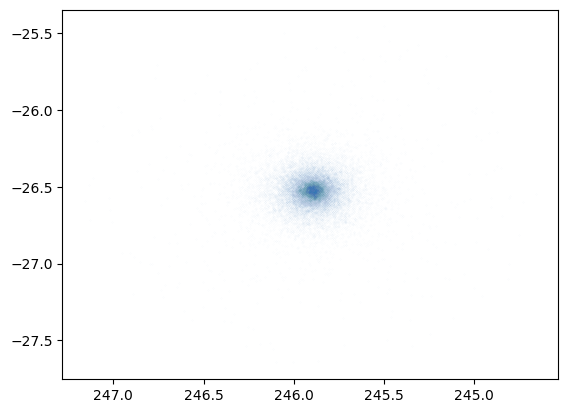

In [4]:
plt.scatter(m4_df.ra, m4_df.dec, s=0.0001)
plt.gca().invert_xaxis()

That looks pretty globular clustery to me.  Let's now pull objects from the Gaia catalog in a box around this location, specifically a 3 degree x 3 degree box centered at `RA=246, dec=-26.5`.  We'll grab object IDs, sky locations, parallaxes, errors, proper motions, etc.

The data corresponding to the query below can be found [here](https://scicomp.gw.observer/view/data/m4_gaia_source.csv).

```sql
SELECT TOP 1000000 gaia_source.designation,gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.parallax,gaia_source.parallax_error,gaia_source.parallax_over_error,gaia_source.pm,gaia_source.pmra,gaia_source.pmra_error,gaia_source.pmdec,gaia_source.pmdec_error,gaia_source.astrometric_n_good_obs_al,gaia_source.astrometric_chi2_al,gaia_source.visibility_periods_used,gaia_source.phot_g_mean_flux_over_error,gaia_source.phot_g_mean_mag,gaia_source.phot_bp_mean_flux_over_error,gaia_source.phot_bp_mean_mag,gaia_source.phot_rp_mean_flux_over_error,gaia_source.phot_rp_mean_mag,gaia_source.phot_bp_rp_excess_factor,gaia_source.bp_rp,gaia_source.radial_velocity,gaia_source.radial_velocity_error
FROM gaiadr3.gaia_source
WHERE 
CONTAINS(
	POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),
	BOX('ICRS',246,-26.5,3,3)
)=1
```

In [5]:
df = pd.read_csv('../data/m4_gaia_source.csv')
print(len(df))

494996


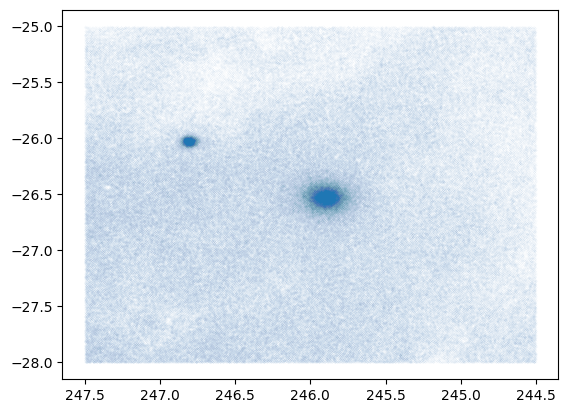

In [6]:
plt.scatter(df.ra, df.dec, s=0.0001)
plt.gca().invert_xaxis()

It looks like we were successful in finding M4, and another cluster may have come along for the ride.  This is a pretty big data set, so we have room to remove some of the noisiest observations to reduce it.

In [7]:
dq_sel = (df['parallax_over_error'] < 50.) & (df['pmra_error'] < 1.5) & (df['pmdec_error'] < 1.5)
df = df[dq_sel]
print(len(df))

346614


# Dense neural network classifiers

Let's try to build a classifier that, given a star's properties available in the full Gaia catalog, is able to predict whether that star is a member of the globular cluster (we're focusing on M4 specifically at the moment, but generalizing what can be learned here to other clusters would make it a powerful tool!).

First we'll need to perform the cross-matching between the two data sets.  Since we'll want to train on values from the full Gaia catalog, it will be useful to construct a selection array that selects for the cluster members identified in the M4 mini-catalog.  We'll use `pandas` `.isin()` methods to do this.

In [8]:
m4_sel = df['source_id'].isin(m4_df.source_id)

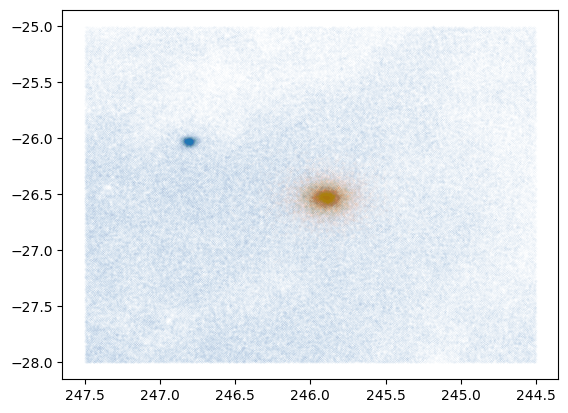

In [9]:
plt.scatter(df.ra[~m4_sel], df.dec[~m4_sel], s=0.0001)
plt.scatter(df.ra[m4_sel], df.dec[m4_sel], s=0.0001)
plt.gca().invert_xaxis()

Sweet.  Let's start off simple and build a classifier based on sky position only.

In [10]:
df.columns

Index(['designation', 'source_id', 'ra', 'dec', 'parallax', 'parallax_error',
       'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'astrometric_n_good_obs_al', 'astrometric_chi2_al',
       'visibility_periods_used', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity',
       'radial_velocity_error'],
      dtype='object')

In [11]:
params = ['ra', 'dec']
X = np.array(df[params])
X.shape

(346614, 2)

It's always good to check for missing values.

In [12]:
np.count_nonzero(np.any(np.isnan(X), axis=1))

0

It doesn't look like we have any here, but they'll likely be encountered in the future.  The information available for each object in the catalog depends on how many times the object was observed (indicated by `visibility_periods_used`).  For example, an object observed only once would have a measured location (RA and dec), but no proper motion, etc.  If there _were_ missing values, we would remove them like so.

In [13]:
nans = np.any(np.isnan(X), axis=1)
X = X[~nans]

n_classes = 2
y = m4_sel.astype(int)[~nans]

Let's standardize our data by transforming it to have a $\vec{0}$ mean and unit 1-D variances.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
transformer = StandardScaler()

X = jnp.array(transformer.fit_transform(X))
y = jnp.array(y)

Let's put this all into a function for easy reuse later.

In [16]:
def build_design_matrix_and_target(params, target_sel=m4_sel, catalog=df):
    '''Prepare a design matrix with the requested parameters, removing nan's and standardizing'''
    X = np.array(df[params])
    nans = np.any(np.isnan(X), axis=1)
    X = X[~nans]

    n_classes = 2
    y = m4_sel.astype(int)[~nans]

    transformer = StandardScaler()

    X = jnp.array(transformer.fit_transform(X))
    y = jnp.array(y)
    return X, y

In [17]:
X, y = build_design_matrix_and_target(params)

Now we'll randomly select $10\%$ of the data to reserve for testing and use the rest for training.  We also need to prepare our output vectors.  In this case we have a simple binary classification task, but to simplify the transition from our previous use of a dense NN to classify handwritten digits, let's treat the problem as if it's a multi-class problem, i.e., use two output nodes and integer labels.

In [18]:
m = X.shape[0]
test_frac = 0.1
test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
train_sel = ~test_sel
n_test = np.count_nonzero(test_sel)
n_train = m - n_test

Where for MNIST we used builtin methods from `tensorflow_datasets` to batch our data, we'll need to do our own batching here.  We'll make a new dimension to the data that will cover batches, and we'll drop the leftover bits that don't divide evenly.

In [19]:
batch_size = 64
n_batches = n_train // batch_size

X_train = X[train_sel][:n_batches * batch_size].reshape((n_batches, batch_size, *X.shape[1:]))
y_train = y[train_sel][:n_batches * batch_size].reshape((n_batches, batch_size, *y.shape[1:]))
X_train.shape, y_train.shape

((4872, 64, 2), (4872, 64))

Let's make functions for these as well.

In [20]:
def sel_test_data(m, test_frac=0.1):
    test_sel = np.random.choice([True, False], size=m, p=[test_frac, 1-test_frac])
    return test_sel

def batch_data(X, y, batch_size=64):
    n_batches = X.shape[0] // batch_size

    X_batched = X[:n_batches * batch_size].reshape((n_batches, batch_size, *X.shape[1:]))
    y_batched = y[:n_batches * batch_size].reshape((n_batches, batch_size, *y.shape[1:]))
    return X_batched, y_batched

In [21]:
test_sel = sel_test_data(X.shape[0])
train_sel = ~test_sel
X_train, y_train = batch_data(X[train_sel], y[train_sel])

We now have everything prepared for model training.  Let's start off with the same basic architecture we used in the previous example, with fewer nodes in our hidden layers (we only have 2 input features, compared to all the pixels with the MNIST data).

In [22]:
n_classes = 2

class DenseClassifier(nn.Module):
    """A simple dense classifier."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(n_classes)(x)
        return x

Let's take a look at the summary of the model.

In [23]:
dummy_input = jnp.ones((1, 2))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,2]  │ float32[1,2]  │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,2]  │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[2,10]    │
│         │                 │               │               │                  │
│         │                 │               │               │ 30 (120 B)       │
├─────────┼────────────────

It looks like our model has $162$ trainable parameters.  Let's train them.

We're going to mostly cut and paste all the metric and training bits from our last Dense-NN modeling effort.

In [24]:
from clu import metrics
from flax.training import train_state
from flax import struct
import optax

In [25]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
   metrics: Metrics

In [26]:
def create_train_state(model, rng, learning_rate):
    params = model.init(rng, dummy_input)['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=model.apply, params=params, tx=tx,
        metrics=Metrics.empty())

In [27]:
@jax.jit
def train_step(state, batch, label):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [28]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [29]:
learning_rate = 0.01

state = create_train_state(dnn, jax.random.PRNGKey(0), learning_rate)

In [30]:
def train(X_train, y_train, state, n_epochs=20, verbose=True, metrics_history=None):
  if metrics_history is None:
    metrics_history = {'train_loss': [],
                    'train_accuracy': [],
                    'test_loss': [],
                    'test_accuracy': []}

  for epoch in range(n_epochs):
    for batch, label in zip(X_train, y_train):
      # Run optimization steps over training batches and compute batch metrics
      state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
      state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    test_state = compute_metrics(state=test_state, batch=X[test_sel], label=y[test_sel])

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    if verbose:
      print(f"train epoch: {epoch+1}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {epoch+1}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
  return state, metrics_history

In [31]:
state, metrics_history = train(X_train, y_train, state)

train epoch: 1, loss: 0.08563237637281418, accuracy: 96.04371643066406
test epoch: 1, loss: 0.27922120690345764, accuracy: 94.52224731445312
train epoch: 2, loss: 0.0851210206747055, accuracy: 96.06136322021484
test epoch: 2, loss: 0.17088551819324493, accuracy: 94.52224731445312
train epoch: 3, loss: 0.08513877540826797, accuracy: 96.06905364990234
test epoch: 3, loss: 0.13159340620040894, accuracy: 94.52224731445312
train epoch: 4, loss: 0.08504387736320496, accuracy: 96.08092498779297
test epoch: 4, loss: 0.1102934181690216, accuracy: 94.7062759399414
train epoch: 5, loss: 0.08499504625797272, accuracy: 96.0732192993164
test epoch: 5, loss: 0.09994954615831375, accuracy: 95.16059875488281
train epoch: 6, loss: 0.08495697379112244, accuracy: 96.07161712646484
test epoch: 6, loss: 0.13311266899108887, accuracy: 94.52224731445312
train epoch: 7, loss: 0.08508270978927612, accuracy: 96.07771301269531
test epoch: 7, loss: 0.13166756927967072, accuracy: 94.52224731445312
train epoch: 8, l

Let's look at the accuracy over the training epochs.

In [32]:
def plot_metrics(metrics_history):
    # Plot loss and accuracy in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train','test'):
        ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
        ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    return fig, (ax1, ax2)

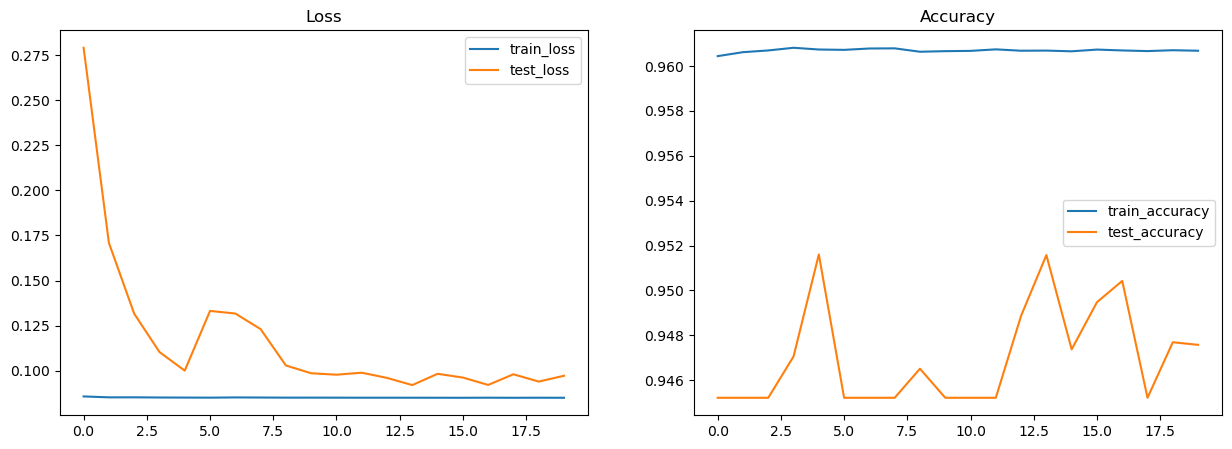

In [33]:
plot_metrics(metrics_history);

Not a ton of improvement on the testing loss — and remember that $\sim 96\%$ of the objects in our set are _not_ part of the cluster — getting accuracies around that is not very difficult. Let's get a visual of how the classifier is doing.

Remember that the output of our network for a single object is a two-element vector, and a larger value in the first column indicates a non-cluster-member prediction, and a larger second value indicates a cluster-member prediction. 

In [34]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, batch)
  return logits.argmax(axis=1)

pred = pred_step(state, X[test_sel])
print(jnp.count_nonzero(pred))

194


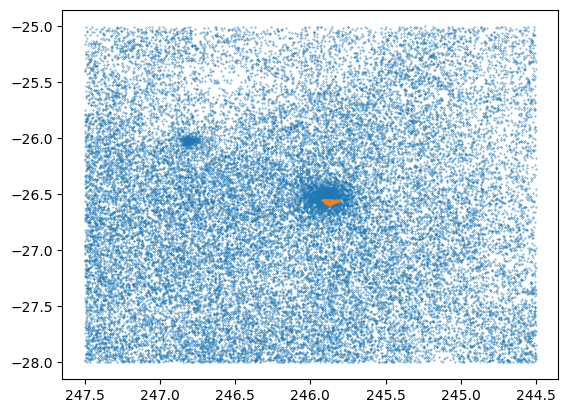

In [35]:
pred_m4_sel = np.array(pred, dtype=bool)
plt.scatter(df.ra[test_sel][~pred_m4_sel], df.dec[test_sel][~pred_m4_sel], s=.1)
plt.scatter(df.ra[test_sel][pred_m4_sel], df.dec[test_sel][pred_m4_sel], s=.1)
plt.gca().invert_xaxis()

Instead of turning the output into discrete prediction, let's look at the difference (remember these are "logit"s) of the values from the output nodes to see if it's picking up hints of something useful.

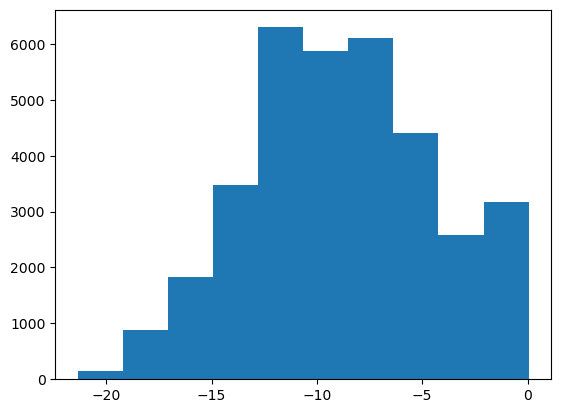

In [36]:
outputs = state.apply_fn({'params': state.params}, X[test_sel])
plt.hist(jnp.diff(outputs, axis=1).flatten());

Remember these go into an `argmax()` to make a prediction, so what we really care about is the difference between node outputs for a given sample.

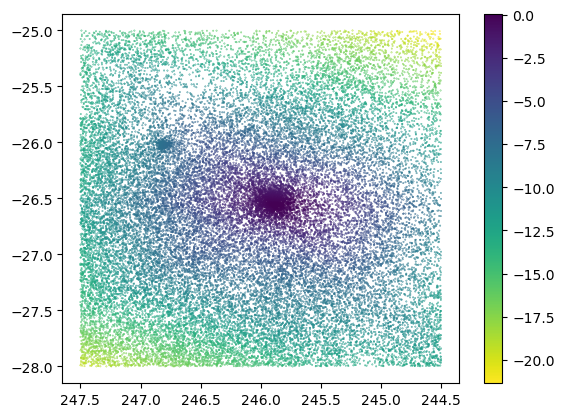

In [37]:
plt.scatter(df.ra[test_sel], df.dec[test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r')
plt.colorbar()

plt.gca().invert_xaxis()

Interesting.  So even though it's not able to make any confident predictions for stars being in the cluster, it's at least able to tell the part of the sky that's most likely to contain them...

Let's include more features.

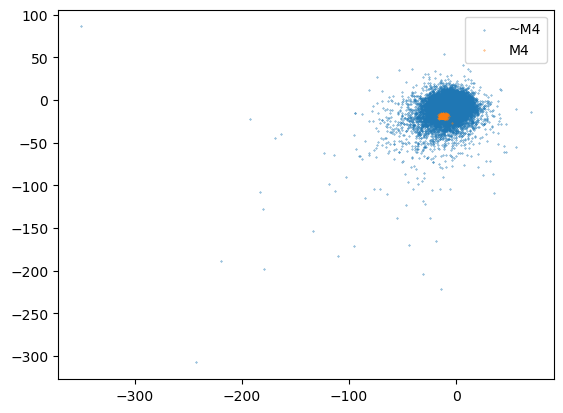

In [38]:
plt.scatter(df.pmra[~m4_sel], df.pmdec[~m4_sel], s=.1, label='~M4')
plt.scatter(df.pmra[m4_sel], df.pmdec[m4_sel], s=.1, label='M4')
# plt.xlim(-25, 10)
# plt.ylim(-25, 10)
plt.legend();

In [39]:
params = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']

X, y = build_design_matrix_and_target(params)

In [40]:
test_sel = sel_test_data(X.shape[0])
train_sel = ~test_sel
X_train, y_train = batch_data(X[train_sel], y[train_sel])

In [41]:
dummy_input = jnp.ones((1, len(params)))
dnn = DenseClassifier()
print(dnn.tabulate(jax.random.PRNGKey(0), dummy_input))


                            DenseClassifier Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module          ┃ inputs        ┃ outputs       ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ DenseClassifier │ float32[1,5]  │ float32[1,2]  │                  │
├─────────┼─────────────────┼───────────────┼───────────────┼──────────────────┤
│ Dense_0 │ Dense           │ float32[1,5]  │ float32[1,10] │ bias:            │
│         │                 │               │               │ float32[10]      │
│         │                 │               │               │ kernel:          │
│         │                 │               │               │ float32[5,10]    │
│         │                 │               │               │                  │
│         │                 │               │               │ 60 (240 B)       │
├─────────┼────────────────

In [42]:
learning_rate = 0.01

state = create_train_state(dnn, jax.random.PRNGKey(0), learning_rate)

In [43]:
state, metrics_history = train(X_train, y_train, state)

train epoch: 1, loss: 0.034641481935977936, accuracy: 98.57374572753906
test epoch: 1, loss: 0.6184062957763672, accuracy: 94.54377746582031
train epoch: 2, loss: 0.0329398550093174, accuracy: 98.6314468383789
test epoch: 2, loss: 0.038740869611501694, accuracy: 98.39947509765625
train epoch: 3, loss: 0.032517943531274796, accuracy: 98.64427185058594
test epoch: 3, loss: 0.03869863972067833, accuracy: 98.3735122680664
train epoch: 4, loss: 0.03234413266181946, accuracy: 98.66511535644531
test epoch: 4, loss: 0.03222882002592087, accuracy: 98.71092224121094
train epoch: 5, loss: 0.032149169594049454, accuracy: 98.66639709472656
test epoch: 5, loss: 0.03435163199901581, accuracy: 98.67054748535156
train epoch: 6, loss: 0.03211170434951782, accuracy: 98.6526107788086
test epoch: 6, loss: 0.03194168582558632, accuracy: 98.72245788574219
train epoch: 7, loss: 0.03209708258509636, accuracy: 98.65709686279297
test epoch: 7, loss: 0.032084040343761444, accuracy: 98.73976135253906
train epoch: 

(<Figure size 1500x500 with 2 Axes>,
 (<Axes: title={'center': 'Loss'}>, <Axes: title={'center': 'Accuracy'}>))

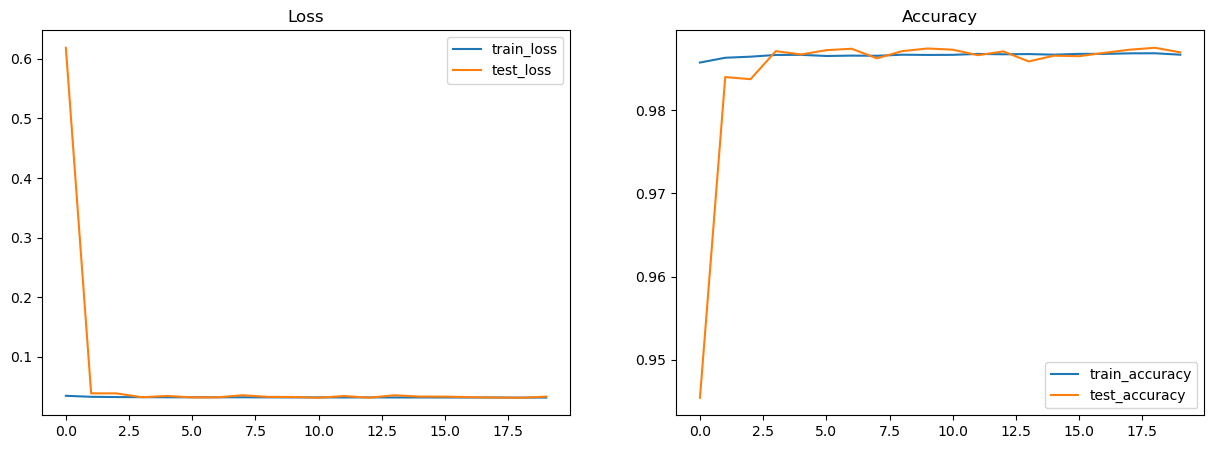

In [44]:
plot_metrics(metrics_history)

In [45]:
pred = pred_step(state, X[test_sel])
print(jnp.count_nonzero(pred))

1951


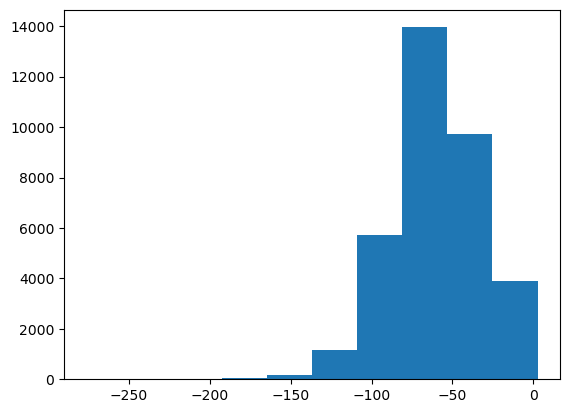

In [46]:
outputs = state.apply_fn({'params': state.params}, X[test_sel])
plt.hist(jnp.diff(outputs, axis=1).flatten());

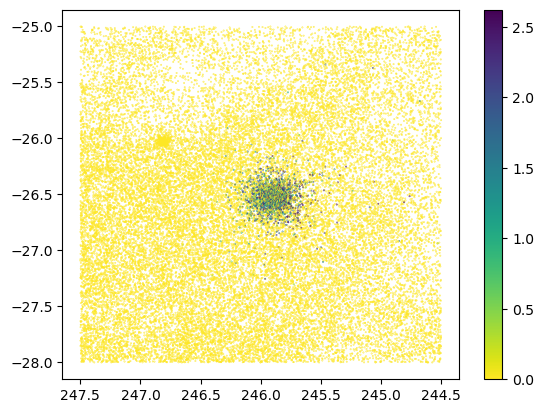

In [47]:
plt.scatter(df.ra[test_sel], df.dec[test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r', vmin=0)
plt.colorbar()

plt.gca().invert_xaxis()

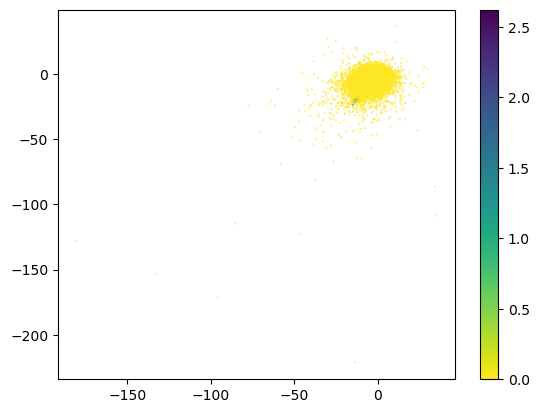

In [48]:
plt.scatter(df.pmra[test_sel], df.pmdec[test_sel], c=jnp.diff(outputs, axis=1), s=.1, cmap='viridis_r', vmin=0)
plt.colorbar()